In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network

## Template 03
## FIFA dataset

<img src='../../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [ ]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

from collections.abc import Callable
from typing import Literal

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn


from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [ ]:
print (fn_plot_torch_hist.__doc__)

None


In [ ]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


In [ ]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input'
outDir = '../output'
modelDir = '../models'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE)

#rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 2001 # number of epochs
BATCH_SIZE = 256 # batch of 32 samples
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [ ]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## Read FIFA 2019 data set

In [ ]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [ ]:
for col in data_df.columns:
    print(f'{col}: {data_df[col].unique}')

Unnamed: 0: <bound method Series.unique of 0            0
1            1
2            2
3            3
4            4
         ...  
18202    18202
18203    18203
18204    18204
18205    18205
18206    18206
Name: Unnamed: 0, Length: 18207, dtype: int64>
ID: <bound method Series.unique of 0        158023
1         20801
2        190871
3        193080
4        192985
          ...  
18202    238813
18203    243165
18204    241638
18205    246268
18206    246269
Name: ID, Length: 18207, dtype: int64>
Name: <bound method Series.unique of 0                  L. Messi
1         Cristiano Ronaldo
2                 Neymar Jr
3                    De Gea
4              K. De Bruyne
                ...        
18202          J. Lundstram
18203    N. Christoffersson
18204             B. Worman
18205        D. Walker-Rice
18206             G. Nugent
Name: Name, Length: 18207, dtype: object>
Age: <bound method Series.unique of 0        31
1        33
2        26
3        27
4        27
         ..


In [ ]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,18207.0,9103.000000,5256.052511,0.0,4551.5,9103.0,13654.5,18206.0
ID,18207.0,214298.338606,29965.244204,16.0,200315.5,221759.0,236529.5,246620.0
Age,18207.0,25.122206,4.669943,16.0,21.0,25.0,28.0,45.0
Overall,18207.0,66.238699,6.908930,46.0,62.0,66.0,71.0,94.0
Potential,18207.0,71.307299,6.136496,48.0,67.0,71.0,75.0,95.0
Special,18207.0,1597.809908,272.586016,731.0,1457.0,1635.0,1787.0,2346.0
International Reputation,18159.0,1.113222,0.394031,1.0,1.0,1.0,1.0,5.0
Weak Foot,18159.0,2.947299,0.660456,1.0,3.0,3.0,3.0,5.0
Skill Moves,18159.0,2.361308,0.756164,1.0,2.0,2.0,3.0,5.0
Jersey Number,18147.0,19.546096,15.947765,1.0,8.0,17.0,26.0,99.0


In [ ]:
data_df[data_df['Position'].isnull()]

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
5018,5018,153160,R. Raldes,37,https://cdn.sofifa.org/players/4/19/153160.png,Bolivia,https://cdn.sofifa.org/flags/53.png,70,70,NaN,...,64.0,79.0,70.0,70.0,16.0,8.0,11.0,12.0,13.0,NaN
6736,6736,175393,J. Arce,33,https://cdn.sofifa.org/players/4/19/175393.png,Bolivia,https://cdn.sofifa.org/flags/53.png,68,68,NaN,...,67.0,12.0,34.0,33.0,16.0,13.0,15.0,16.0,8.0,NaN
7922,7922,195905,L. Gutiérrez,33,https://cdn.sofifa.org/players/4/19/195905.png,Bolivia,https://cdn.sofifa.org/flags/53.png,67,67,NaN,...,54.0,72.0,71.0,64.0,11.0,7.0,8.0,12.0,12.0,NaN
9905,9905,226044,R. Vargas,23,https://cdn.sofifa.org/players/4/19/226044.png,Bolivia,https://cdn.sofifa.org/flags/53.png,66,69,NaN,...,64.0,19.0,24.0,23.0,13.0,11.0,11.0,7.0,9.0,NaN
10628,10628,216751,D. Bejarano,26,https://cdn.sofifa.org/players/4/19/216751.png,Bolivia,https://cdn.sofifa.org/flags/53.png,65,66,NaN,...,57.0,68.0,69.0,68.0,14.0,12.0,11.0,14.0,12.0,NaN
13236,13236,177971,J. McNulty,33,https://cdn.sofifa.org/players/4/19/177971.png,Scotland,https://cdn.sofifa.org/flags/42.png,62,62,Rochdale,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13237,13237,195380,J. Barrera,29,https://cdn.sofifa.org/players/4/19/195380.png,Nicaragua,https://cdn.sofifa.org/flags/86.png,62,62,Boyacá Chicó FC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13238,13238,139317,J. Stead,35,https://cdn.sofifa.org/players/4/19/139317.png,England,https://cdn.sofifa.org/flags/14.png,62,62,Notts County,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13239,13239,240437,A. Semprini,20,https://cdn.sofifa.org/players/4/19/240437.png,Italy,https://cdn.sofifa.org/flags/27.png,62,72,Brescia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13240,13240,209462,R. Bingham,24,https://cdn.sofifa.org/players/4/19/209462.png,England,https://cdn.sofifa.org/flags/14.png,62,66,Hamilton Academical FC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [ ]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [ ]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [ ]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [ ]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [ ]:
labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [ ]:
# splitting in train ans test datasets
train_df, test_df = train_test_split(data_df,
                                     stratify=data_df['Position'],
                                     test_size=TEST_SIZE,
                                     random_state=RANDOM_STATE )
train_df.shape, test_df.shape

((14517, 34), (3630, 34))

In [ ]:
# important to reset the indies as we will be fetching by index

train_df = train_df.reset_index(drop=True)
display (train_df.head())

test_df = test_df.reset_index(drop=True)
display(test_df.head())

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,62.0,57.0,51.0,47.0,61.0,42.0,27.0,41.0,59.0,...,63.0,52.0,21.0,16.0,12.0,11.0,7.0,10.0,12.0,11.0
1,3,55.0,42.0,58.0,60.0,62.0,61.0,56.0,52.0,60.0,...,60.0,53.0,29.0,25.0,22.0,7.0,12.0,6.0,9.0,10.0
2,2,56.0,36.0,61.0,51.0,69.0,60.0,52.0,57.0,66.0,...,54.0,50.0,23.0,22.0,27.0,12.0,10.0,9.0,9.0,14.0
3,0,11.0,12.0,35.0,12.0,12.0,22.0,13.0,40.0,20.0,...,20.0,60.0,11.0,10.0,15.0,69.0,70.0,66.0,67.0,73.0
4,2,66.0,44.0,66.0,48.0,70.0,74.0,75.0,62.0,67.0,...,76.0,60.0,40.0,38.0,28.0,14.0,12.0,6.0,12.0,12.0


,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,2,66.0,33.0,72.0,55.0,81.0,69.0,65.0,61.0,79.0,...,57.0,68.0,23.0,26.0,30.0,12.0,14.0,16.0,6.0,10.0
1,2,71.0,43.0,68.0,43.0,72.0,74.0,69.0,70.0,78.0,...,64.0,66.0,39.0,26.0,16.0,14.0,14.0,13.0,6.0,8.0
2,2,67.0,43.0,61.0,49.0,65.0,48.0,35.0,44.0,65.0,...,54.0,47.0,49.0,13.0,19.0,9.0,12.0,15.0,12.0,13.0
3,2,55.0,37.0,69.0,45.0,67.0,50.0,51.0,64.0,62.0,...,53.0,61.0,55.0,61.0,57.0,13.0,7.0,10.0,8.0,12.0
4,1,25.0,82.0,61.0,20.0,51.0,25.0,33.0,63.0,60.0,...,42.0,67.0,77.0,78.0,70.0,15.0,12.0,13.0,14.0,15.0


In [ ]:
list(labels.keys())

[0, 1, 2, 3]

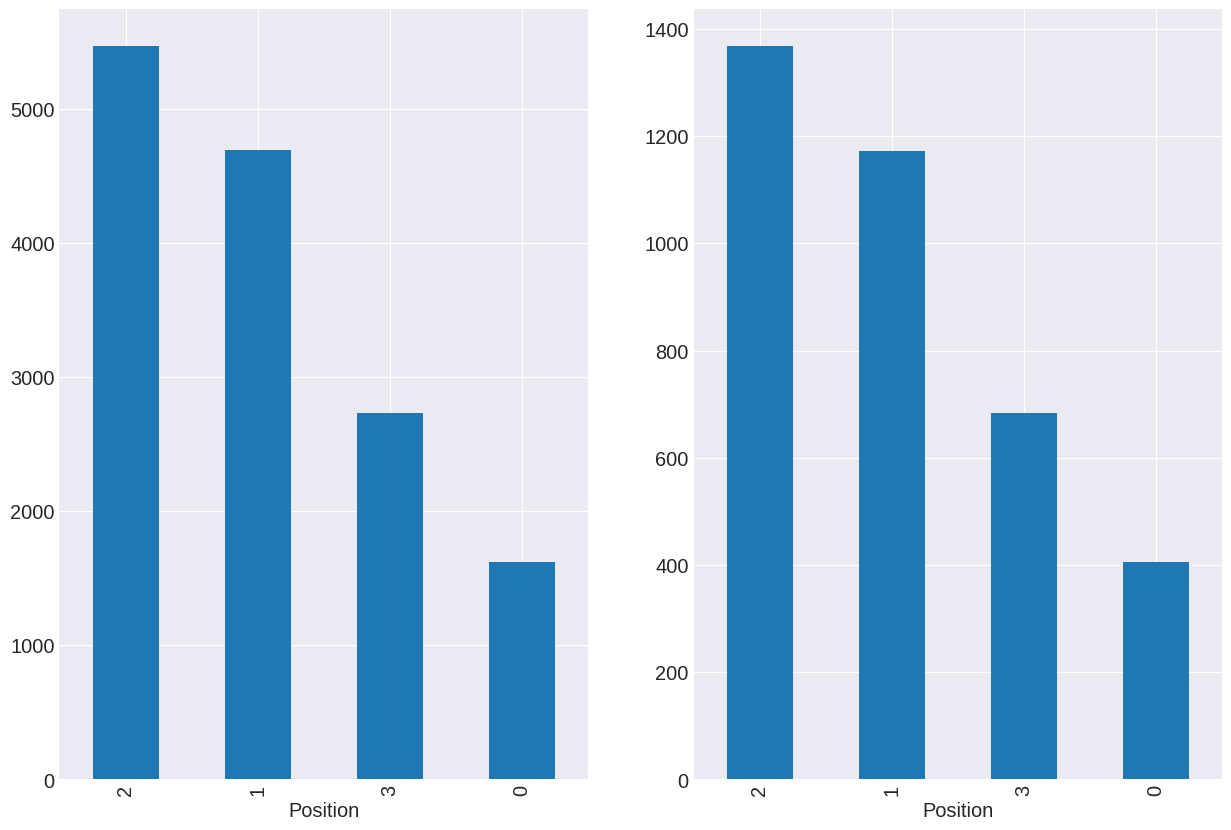

In [ ]:
fig, axes = plt.subplots(1,2)
ax = axes[0]
train_df['Position'].value_counts().plot(kind = "bar", ax = ax);

ax = axes[1]
test_df['Position'].value_counts().plot(kind = "bar", ax = ax);

## Data splitting

In [ ]:


features_df = data_df.drop('Position', axis=1) # assigning features feature_df
labels = data_df['Position'].to_numpy() # labels
# train test split
X_train, X_test, y_train, y_test = train_test_split(features_df,labels,stratify=labels,test_size=TEST_SIZE, random_state=RANDOM_STATE)
# Standard Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # fit and transform scaling model on train data
X_test = scaler.transform(X_test) # scaling



### Converting to Datasets

In [ ]:
type(X_train), type(X_test), type(y_train), type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [ ]:
X_train


array([[ 0.84396466,  0.27358763, -0.52239617, ..., -0.37748688,
        -0.25744747, -0.31840455],
       [ 0.4854738 , -0.58924402, -0.04661844, ..., -0.62037214,
        -0.43407708, -0.37415646],
       [ 0.53668678, -0.93437669,  0.15728631, ..., -0.4382082 ,
        -0.43407708, -0.15114884],
       ...,
       [-1.87032331, -2.37242944, -2.15363411, ...,  2.17280829,
         2.15649058,  2.24618307],
       [-1.87032331, -1.96977467, -1.54191988, ...,  3.1443493 ,
         2.50974981,  2.74795021],
       [-1.30698052, -2.142341  , -2.35753885, ...,  3.08362799,
         3.03963865,  3.08246164]])

## Prepare Model

In [ ]:
# calling class Sequential and pass all layers as a list
import torch # type: ignore
torch.__version__

'2.3.0+cu121'

In [ ]:
torch.cuda.is_available()

False

In [ ]:
torch.version.cuda

'12.1'

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'


## Define Model

In [ ]:
#  input_dim = X_train.shape[1]

# model = nn.Sequential(
#     nn.Linear( input_dim, 18),
#     nn.Tanh(),
#     nn.Linear( 18, 4),).to(device=device)
import torch # type: ignore
from torch.utils.data import Dataset, DataLoader # type: ignore

class FifaDataset(Dataset):
    def __init__(self,X,y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

In [ ]:
train_dataset = FifaDataset(X_train,y_train)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)


for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Batch {batch_idx+1}", end='')
    print('Data: ',data.shape, end=' ')
    print('Target: ',target.shape)

Batch 1Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 2Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 3Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 4Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 5Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 6Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 7Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 8Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 9Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 10Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 11Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 12Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 13Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 14Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 15Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 16Data:  torch.Size([256, 33]) Target:  tor

In [ ]:
test_dataset = FifaDataset(X_test,y_test)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)


for batch_idx, (data, target) in enumerate(test_loader):
    print(f"Batch {batch_idx+1}", end='')
    print('Data: ',data.shape, end=' ')
    print('Target: ',target.shape)

Batch 1Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 2Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 3Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 4Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 5Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 6Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 7Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 8Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 9Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 10Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 11Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 12Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 13Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 14Data:  torch.Size([256, 33]) Target:  torch.Size([256])
Batch 15Data:  torch.Size([46, 33]) Target:  torch.Size([46])


In [ ]:
print(model)

Sequential(
  (0): Linear(in_features=33, out_features=18, bias=True)
  (1): Tanh()
  (2): Linear(in_features=18, out_features=4, bias=True)
)


## Alternate model creation

class Model(nn.module):


In [ ]:
model.compile()

In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[ 9.2062e-02, -4.3501e-02, -1.4794e-01,  1.0717e-02,  1.6225e-01,
          -7.7643e-02, -5.6670e-02,  1.3613e-01, -2.4222e-02, -6.6486e-02,
          -3.5062e-02,  6.3746e-03, -1.4182e-01, -4.9749e-02,  1.6879e-01,
          -3.7317e-02,  1.5855e-01, -6.7960e-02, -7.0020e-02, -5.1887e-02,
          -1.5565e-01, -1.0485e-01,  1.0520e-01, -1.3059e-01,  5.9465e-02,
           1.6379e-01, -2.2121e-02,  7.6153e-02,  8.1313e-02, -1.2426e-01,
          -6.7123e-02, -5.4516e-02,  1.6798e-01],
         [-1.5537e-01,  1.0537e-01,  1.6350e-01,  1.3764e-01,  7.4190e-02,
           7.7494e-02, -9.2818e-03,  8.7583e-02,  1.5868e-01, -5.5976e-02,
           1.6820e-01,  2.7665e-02, -1.2210e-01, -1.2494e-01,  6.1399e-02,
          -2.4561e-02, -7.6685e-02,  8.8150e-02, -9.1821e-02, -8.3203e-02,
           3.2539e-02, -3.1431e-02, -1.4688e-01, -5.2295e-02, -6.1178e-02,
          -7.4187e-02,  1.3552e-01, -2.6404e-02, -1.0632e-01,  5.1576e-02,
           2.9993e-02, -1.3

In [ ]:
print(f"Num Parameters: {len(list(model.parameters()))}")
print(f"Layer 1: Weights :{list(model.parameters())[0].shape}")
print(f"Layer 1: bais :{list(model.parameters())[1].shape}")
print(f"Layer 2: Weights :{list(model.parameters())[2].shape}")
print(f"Layer 2: bais :{list(model.parameters())[3].shape}")

Num Parameters: 4
Layer 1: Weights :torch.Size([18, 33])
Layer 1: bais :torch.Size([18])
Layer 2: Weights :torch.Size([4, 18])
Layer 2: bais :torch.Size([4])


In [ ]:
y_train.shape

(14517,)

### Convert data into tensor

In [ ]:
train_X = torch.tensor(X_train, dtype=torch.float32, device=device)
train_y = torch.tensor(y_train, dtype=torch.int64, device=device)

test_X = torch.tensor(X_test, dtype=torch.float32, device=device)
test_y = torch.tensor(y_test, dtype=torch.int64, device=device)

In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
train_X[:1].shape, train_X[0].shape

(torch.Size([1, 33]), torch.Size([33]))


### use train_X[:1] to keep dimensions rather than train_X[0]

## Making predictions

In [ ]:
predict_prob = model(train_X[:1]) # make predictions
predict_prob.detach().numpy()

array([[-0.40813166, -0.18573728,  0.13504395, -0.1031108 ]],
      dtype=float32)

In [ ]:
y_train[0]

3

In [ ]:
predict_prob

tensor([[-0.4081, -0.1857,  0.1350, -0.1031]], grad_fn=<AddmmBackward0>)

### Training model

In [ ]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizers
optmizer = torch.optim.Adam(model.parameters(), lr = ALPHA)

# Iterations
for epoch in range(EPOCHS):
    model.train() # set the model in the training mode
    predict_prob = model(train_X) # make predictions
    curr_loss = loss_fn(predict_prob, train_y) # calculate loss

    #####-----------------------------
    ## Back prop steps  --------------
    #### -----------------------------

    optmizer.zero_grad()
    curr_loss.backward()
    optmizer.step()
    #model.eval() # set the model in the evaluation mode



In [ ]:
# Lets see prediction for first row
predict_prob = model(train_X[:1]) # make predictions
predict_prob.detach().cpu().numpy()

array([[-2.0880373, -3.5062962,  1.9967445,  5.2325635]], dtype=float32)

In [ ]:
predict_prob.argmax().item(), train_y[0].item()

(3, 3)

In [ ]:
del model

model = nn.Sequential(
    nn.Linear( input_dim, 18),
    nn.Tanh(),
    nn.Linear( 18, 4)
).to(device=device)

In [ ]:
# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Optimizers
optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)

# Some lists to collect data
loss = []
tloss = []
n_epoch = []
acc = []
tacc = []

# Iterations
for epoch in range (EPOCHS):

    model.train() # Set the model in training mode

    predict_prob = model(train_X) # make predictions

    curr_loss = loss_fn(predict_prob, train_y) # calculate loss

    ###---------------
    ### Back prop step
    ###---------------
    optimizer.zero_grad()
    curr_loss.backward()
    optimizer.step()

    loss.append ( curr_loss.data.item() ) # append to loss list

    _, y_pred = torch.max(predict_prob, 1) # get predicted class from the probabilities

    curr_acc = accuracy_score( y_train, y_pred.data.cpu()) # move to CPU

    acc.append(curr_acc) # append to accuracy list

    model.eval() # evaluation mode, prevent from learning

    predict_prob_tst = model(test_X) # make predictions on test data

    tcurr_loss = loss_fn( predict_prob_tst, test_y)

    tloss.append( tcurr_loss.data.item())  # append to loss list

    _, y_pred = torch.max(predict_prob_tst, 1) # get predicted class from the probabilities

    tcurr_acc = accuracy_score( y_test, y_pred.data.cpu()) # move to CPU

    tacc.append(tcurr_acc) # append to accuracy list

    n_epoch.append(epoch)


    if epoch % 1000 == 0:
        fmtStr = 'Epoch :{:5d}/{:5d} --- Loss: {:.5f}/{:.5f} | Acc {:.5f}/{:.5f}'

        print (fmtStr.format(epoch, EPOCHS,
                             curr_loss.data.item(),
                             tcurr_loss.data.item(),
                             curr_acc,
                             tcurr_acc))

Epoch :    0/ 2001 --- Loss: 1.35766/1.34192 | Acc 0.39368/0.40606
Epoch : 1000/ 2001 --- Loss: 0.29407/0.30232 | Acc 0.87883/0.86777
Epoch : 2000/ 2001 --- Loss: 0.27246/0.29324 | Acc 0.88868/0.87796


In [ ]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                       'loss' : loss,
                       'test_loss' : tloss,
                       'acc' : acc,
                       'test_acc': tacc})

### Visualization

In [ ]:
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,1.357661,1.341921,0.393676,0.406061
1,1,1.339827,1.324474,0.403251,0.414050
2,2,1.322430,1.307462,0.409864,0.422039
3,3,1.305466,1.290874,0.415031,0.429201
4,4,1.288928,1.274711,0.420473,0.435813


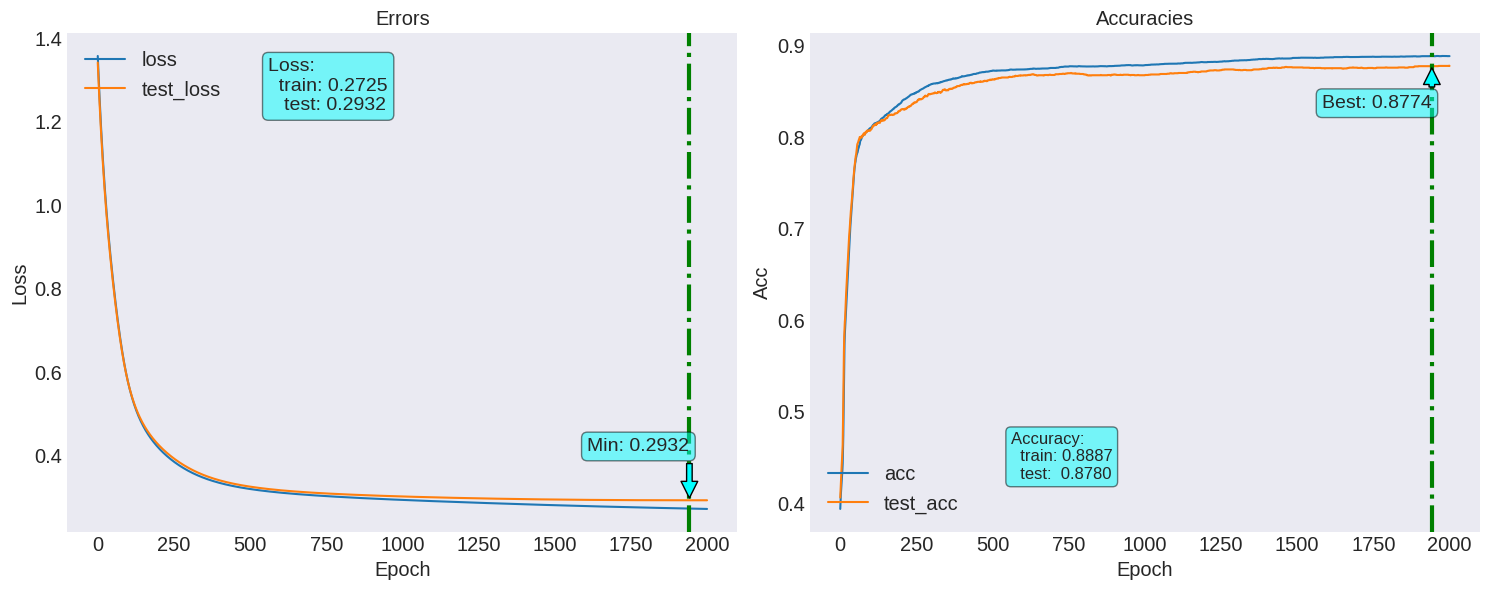

In [ ]:
fn_plot_torch_hist(loss_df)

In [ ]:
outputs = model(train_X)

y_pred = torch.argmax(outputs, dim = 1).cpu().numpy()

y_pred

array([3, 2, 2, ..., 0, 0, 0])

In [ ]:
print(classification_report(train_y.cpu().numpy(), y_pred ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.92      0.93      0.92      4693
           2       0.84      0.87      0.86      5470
           3       0.86      0.79      0.83      2734

    accuracy                           0.89     14517
   macro avg       0.91      0.90      0.90     14517
weighted avg       0.89      0.89      0.89     14517



In [ ]:
labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

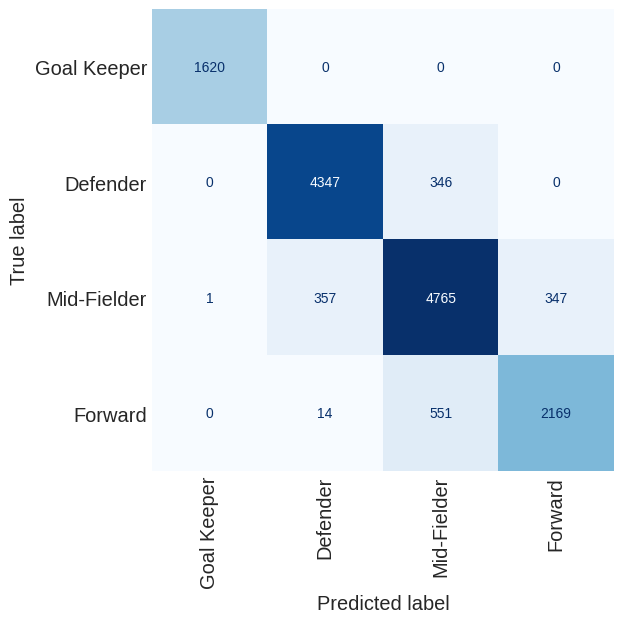

In [ ]:
fn_plot_confusion_matrix(train_y.cpu().numpy(), y_pred, labels=labels)

## Performance on test data